In [13]:
import os
import pretty_midi as pm
import torch
from torchvision import datasets, io, models, ops, transforms, utils
import numpy as np
from torch.nn.modules.activation import Softmax
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [14]:
training = torch.load("train.pt")
target = torch.load("target.pt")

print(training.shape)
print(target.shape)

device = 'cuda'
print(torch.cuda.is_available())

torch.Size([46966, 4, 49])
torch.Size([46966, 1, 49])
True


Welcome!

The network will be trained on 46966 notes.

 epoch 1: train loss 5.1132, train accuracy 10.35%
 epoch 2: train loss 4.2052, train accuracy 14.61%
 epoch 3: train loss 3.7233, train accuracy 17.81%
 epoch 4: train loss 3.4101, train accuracy 20.41%
 epoch 5: train loss 3.1852, train accuracy 22.59%
 epoch 6: train loss 3.0128, train accuracy 24.46%
 epoch 7: train loss 2.8754, train accuracy 26.04%
 epoch 8: train loss 2.7622, train accuracy 27.46%
 epoch 9: train loss 2.6666, train accuracy 28.73%
 epoch 10: train loss 2.5845, train accuracy 29.87%
 epoch 11: train loss 2.5125, train accuracy 30.93%
 epoch 12: train loss 2.4488, train accuracy 31.90%
 epoch 13: train loss 2.3918, train accuracy 32.77%
 epoch 14: train loss 2.3401, train accuracy 33.61%
 epoch 15: train loss 2.2931, train accuracy 34.37%
 epoch 16: train loss 2.2500, train accuracy 35.07%
 epoch 17: train loss 2.2102, train accuracy 35.72%
 epoch 18: train loss 2.1733, train accuracy 36.34%
 epoch 19: train l

Text(0, 0.5, 'accuracy')

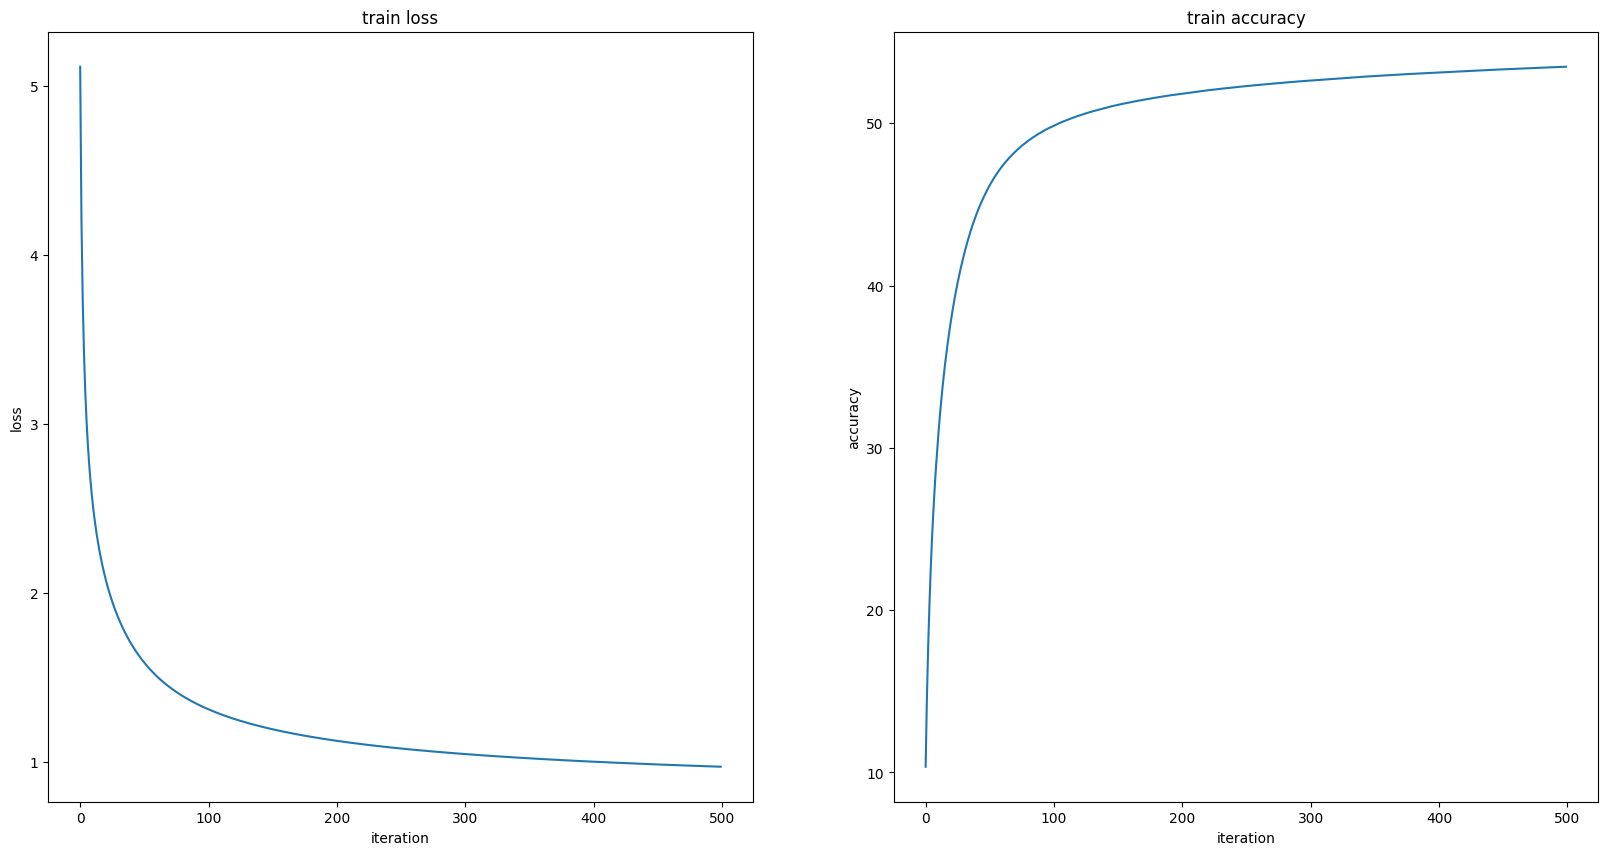

In [45]:
# Size of each weight/bias layer
h1_size = 200
h2_size = 400
h3_size = 500
h4_size = 300

# Create the weights and biases
params = {
    "W0": torch.zeros(4*49, h1_size)*2-1,
    "b0": torch.zeros(h1_size)*2-1, 
    "W1": torch.zeros(h1_size, h2_size)*2-1,
    "b1": torch.zeros(h2_size)*2-1,
    "W2": torch.zeros(h2_size, h3_size)*2-1,
    "b2": torch.zeros(h3_size)*2-1,
    "W3": torch.zeros(h3_size,h4_size)*2-1,
    "b3": torch.zeros(h4_size)*2-1,
    "W4": torch.zeros(h4_size,49)*2-1,
    "b4": torch.zeros(49)*2-1,
    }

# Initialize the weights and biases
def initialize_nn(params):
    for name, param in params.items():
        params[name] = torch.zeros_like(param)
        if "W" in name:
            # initialize weight parameters by drawing random weights
            # from zero-mean Gaussian distribution with std = 0.01
            params[name] = params[name].normal_(0, 0.25)
        # turn on parameter gradients for parameters, and move them to device
        params[name].requires_grad = True

initialize_nn(params)

def nn(input, param_dict):

    # Reshape tensor
    x = input.view(-1 , 4*49)

    # First fully-connected layer
    x = torch.tanh(x @ param_dict['W0'] + param_dict['b0'])
    
    # Second fully-connected layer
    x = torch.tanh(x @ param_dict['W1'] + param_dict['b1'])
    
    # Third fully-connected layer
    x = torch.tanh(x @ param_dict['W2']  + param_dict['b2'])
    
    # Fourth fully-connected layer
    x = torch.tanh(x @ param_dict['W3']  + param_dict['b3'])
    
    # Output layer
    x = x @ param_dict['W4']  + param_dict['b4']

    return x

print("Welcome!\n")


# Display the total number of images to train on
print(f"The network will be trained on {target.shape[0]} notes.\n========================\n")

batch_size = 250 # minibatch size
epochs = 500 # number of epochs to iterate
alpha = 0.05 # learning rate

train_losses = [] # use to append the loss for each minibatch 
train_accs = [] # use to append the acc of minibatch
train_losses_avg = [] # use to append the avg loss for each minibatch 
train_accs_avg = [] # use to append the avg acc of minibatch

# Loop for every epoch
for epoch in range(epochs):

  # Shuffle images each epoch so the network trains on random images
  indices = torch.randperm(training.size()[0])
  training = training[indices]
  target = target[indices]

  # Loop for each minibatch
  for i in range(0, training.shape[0], batch_size):
    # Call the neural network to perform a forward pass
    output = nn(training[i:i+batch_size], params)
    
    # print(output.shape)
    # print(target[i:i+batch_size].squeeze().shape)

    # Compute the loss
    loss = F.cross_entropy(output, target[i:i+batch_size].squeeze())

    # Backpropagation on the loss
    loss.backward()
    
    # Save the loss
    train_losses.append(loss.item())

    # Compute the predicted values
    pred = output.argmax(1)
    # print(pred)
    # print(pred == target[i:i+batch_size].squeeze().argmax(1))
    
    # Save if the predicted number was correct
    train_accs.append(sum(pred == target[i:i+batch_size].squeeze().argmax(1)).item()/batch_size)

    # Update the weights and biases with the gradients
    for (name, param) in params.items():
      with torch.no_grad():
        params[name] -= alpha * params[name].grad
      if param.grad is not None:
        params[name].grad.detach_()
        params[name].grad.zero_()

  # Update the average loss and accuracy
  train_losses_avg.append(sum(train_losses)/((target.shape[0]/batch_size)*(epoch+1)))
  train_accs_avg.append(sum(train_accs)/((target.shape[0]/batch_size)*(epoch+1))*100)

  # Print training progress
  print(f' epoch {epoch+1}: train loss {sum(train_losses)/((target.shape[0]/batch_size)*(epoch+1)):.4f}, train accuracy {sum(train_accs)/((target.shape[0]/batch_size)*(epoch+1))*100:.2f}%')

# plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_losses_avg)
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].plot(train_accs_avg)
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')

In [118]:
# test the code
y = torch.zeros(4, 49)

y[0][19] = 1
y[1][22] = 1
y[2][31] = 1
y[3][48] = 1

print(19+36)
print(22+36)
print(31+36)
print(48+36)

print(y)

output = nn(y, params)

root = output.argmax(1)+36
chord = [root, root+4, root+4+3]

print(chord)


55
58
67
84
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
[tensor([51]), tensor([55]), tensor([58])]


In [3]:
import torch
# Save the tensor to a file
torch.save(params, "params.pt")

{'W0': tensor([[-0.1253, -0.2626,  0.0025,  ...,  0.0191,  0.1999, -0.1715],
        [ 0.2797,  0.1670,  0.0274,  ...,  0.0250,  0.3998, -0.0941],
        [ 0.0588,  0.0823, -0.0764,  ..., -0.0811, -0.0728, -0.2246],
        ...,
        [ 0.0492, -0.2474,  0.0969,  ..., -0.2716, -0.0649, -0.1915],
        [-0.1345,  0.3726, -0.1566,  ...,  0.4226, -0.2772, -0.0033],
        [-0.3578, -0.2487, -0.1677,  ..., -0.0245,  0.1843, -0.2833]],
       requires_grad=True), 'b0': tensor([-0.6820, -0.3196, -0.5436, -0.2975, -0.7196, -0.4644, -0.6463, -0.5479,
        -0.7114, -0.4492, -0.5841, -0.4450, -0.7197, -0.5632, -0.4780, -0.7728,
        -0.4084, -0.5511, -0.5588, -0.5804, -0.6384, -0.4363, -0.6238, -0.8553,
        -0.6655, -0.5079, -0.7802, -0.9027, -0.5837, -0.7353, -0.6336, -0.5857,
        -0.9931, -0.6845, -0.8100, -0.6056, -0.5245, -0.6869, -1.4271, -0.5849,
        -0.6005, -0.6657, -0.2209, -0.7864, -0.5209, -0.5242, -0.6938, -0.5954,
        -0.9105, -0.3989, -0.5366, -0.8090, -